In [48]:
from math import sqrt
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageFilter
import numpy as np
from collections import defaultdict
from skimage import io as io
from skimage import exposure
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.feature import daisy
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.feature import hog
from skimage.feature import corner_harris, corner_subpix, corner_peaks
import cv2
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from time import time
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestRegressor

In [49]:
with open("data/annotations/instances_train2014.json") as read_file:
    train = json.load(read_file)
#with open("data/annotations_trainval2014/annotations/instances_val2014.json") as read_file:
#    val = json.load(read_file)

Number of images in 2014 train: 82783
Number of annotations in 2014 train: 604907
Number of annotations/image in 2014 train: 7.307140354903785
82081
82081
Label density in 2014 train: 0.0913392544362973
dict_keys(['info', 'images', 'licenses', 'annotations', 'categories'])


1person: 185316
2bicycle: 4955
3car: 30785
4motorcycle: 6021
5airplane: 3833
6bus: 4327
7train: 3159
8truck: 7050
9boat: 7590
10traffic light: 9159
11fire hydrant: 1316
13stop sign: 1372
14parking meter: 833
15bench: 6751
16bird: 7290
17cat: 3301
18dog: 3774
19horse: 4666
20sheep: 6654
21cow: 5686
22elephant: 3905
23bear: 903
24zebra: 3685
25giraffe: 3596
27backpack: 6200
28umbrella: 7865
31handbag: 8778
32tie: 4497
33suitcase: 4251
34frisbee: 1862
35skis: 4698
36snowboard: 1960
37sports ball: 4392
38kite: 6560
39baseball bat: 2400
40baseball glove: 2689
41skateboard: 4012
42surfboard: 4161
43tennis racket: 3411
44bottle: 16983
46wine glass: 5618
47cup: 14513
48fork: 3918
49knife: 5536
50spoon: 4287
51bowl: 10064
5

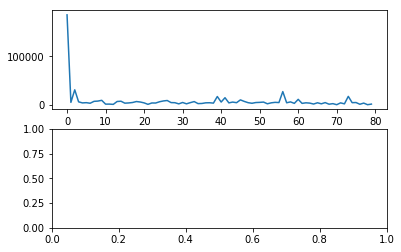


10 least used features 

[('hair drier', 135), ('toaster', 156), ('parking meter', 833), ('bear', 903), ('scissors', 1073), ('microwave', 1189), ('fire hydrant', 1316), ('stop sign', 1372), ('toothbrush', 1377)]



10 most used features 

[('handbag', 8778), ('traffic light', 9159), ('bowl', 10064), ('dining table', 11167), ('cup', 14513), ('bottle', 16983), ('book', 17315), ('chair', 27147), ('car', 30785), ('person', 185316)]




In [50]:
categories = train["categories"]
#print(categories)
train_images = train["images"]
#val_images = val["images"]
print("Number of images in 2014 train: "+str(len(train_images)))
#print("Number of images in 2014 val: "+str(len(val_images)) +"\n")
train_annotations = train["annotations"]
#print(train_annotations[1:20])
#val_annotations = val["annotations"]
print("Number of annotations in 2014 train: "+str(len(train_annotations)))
#print("Number of annotations in 2014 val: "+str(len(val_annotations)) + "\n")
print("Number of annotations/image in 2014 train: "+str(len(train_annotations)/len(train_images)))
#print("Number of annotations/image in 2014 val: " + str(len(val_annotations)/len(val_images)) + "\n")
train_categories = np.zeros(100, dtype=object)
#val_categories = np.zeros(100, dtype=object)
#itemsets = [[] for i in range(581922)]
itemsets = defaultdict(list)
for annotation in train_annotations:
    train_categories[annotation['category_id']] += 1
    itemsets[annotation['image_id']].append(annotation['category_id'])
print(len(itemsets))
unique_itemsets = []
for entry in itemsets:
    if(entry not in unique_itemsets):
        unique_itemsets.append(entry)
print(len(unique_itemsets))
#for annotation in val_annotations:
#    val_categories[annotation['category_id']] += 1
train_categories = train_categories[train_categories != 0]
#val_categories = val_categories[val_categories != 0]
print("Label density in 2014 train: "+str(len(train_annotations)/len(train_categories)/len(train_images)))
#print("Label density in 2014 val: "+str(len(val_annotations)/len(val_categories)/len(val_images)))
print(train.keys())
print("\n")
#print(images[1:10])
#print("\n")
#print(annotations[1:10])
#print("\n")
#print(categories)
for i in range(0, len(train_categories)):
    print(str(categories[i]["id"]) + categories[i]["name"] + ": " + str(train_categories[i]))
    train_categories[i] = (categories[i]["name"], train_categories[i])
#for i in range(0, len(val_categories)):
    #print(categories[i]["name"] + ": " + str(train_categories[i]))
#    val_categories[i] = (categories[i]["name"], val_categories[i])
plt.figure(1)
plt.subplot(211)
plt.plot([i[1] for i in train_categories])
plt.subplot(212)
#plt.plot([i[1] for i in val_categories])
plt.show()
train_categories = sorted(train_categories, key=lambda tup: tup[1], reverse=False)
#val_categories = sorted(val_categories, key=lambda tup: tup[1], reverse=False)
print("\n10 least used features \n")
print(train_categories[0:9])
print("\n")
#print(val_categories[0:9])
print("\n10 most used features \n")
print(train_categories[-10:])
print("\n")
#print(val_categories[-10:])

In [51]:
image_id = 9 #9,25,30,34,36,49
def findAnnotations(id, property):
    items = []
    for annotation in train_annotations: 
        if annotation[property] == id:
            items.append(annotation)
    return items
items = findAnnotations(image_id, 'image_id')

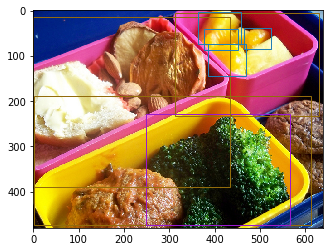

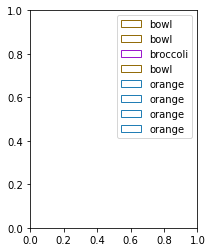

In [52]:
def findValueDictionary(dict,key,value, returnkey):
    for entry in dict:
        if entry[key] == value:
            return entry[returnkey]

image_id_string = str(image_id).zfill(12)
image = np.array(Image.open('data/train2014/COCO_train2014_'+ image_id_string +'.jpg'), dtype=np.uint8)
fig,ax = plt.subplots(1)
ax.imshow(image)
colors = np.random.random((len(categories)+10, 3))
i=0
bbox_list = []
item_list = []
for item in items:
    label = findValueDictionary(categories, 'id', item['category_id'], 'name')
    rect = patches.Rectangle((item['bbox'][0], (item['bbox'][1])), item['bbox'][2], item['bbox'][3],linewidth=1,edgecolor=colors[item['category_id']-1],facecolor='none', label= label)
    ax.add_patch(rect)
    bbox_list.append(rect)
    item_list.append(item['category_id'])
#print(items)
plt.figure(figsize=(3,4))
plt.legend(handles=bbox_list)
plt.show()

In [53]:
def getBoundingBox(x,y,w,h,img):
    return img[y:y+h,x:x+w]


def getBoundingBoxesPicture(annotations, categories, path):
    bounded_images = []
    bounded_annotations = []
    bounded = [[],[]]
    for annotation in annotations:
        image_id = annotation['image_id']
        image_id_string = str(image_id).zfill(12)
        image = np.array(Image.open(path + image_id_string +'.jpg').convert("L").filter(ImageFilter.GaussianBlur(radius = 2)), dtype=np.uint8)
        image_resized = resize(getBoundingBox(int(annotation['bbox'][0]),int(annotation['bbox'][1]),int(annotation['bbox'][2]),int(annotation['bbox'][3]),image)
                               , ( 80, 80),
                       anti_aliasing=True)
        bounded_images.append(image_resized)
        bounded_annotations.append(annotation['category_id'])
    bounded = [len(bounded_images),2]
    bounded[0] = bounded_images
    bounded[1] = bounded_annotations
    return bounded

path = "data/train2014/COCO_train2014_"
category = "category_id"
category_imgs21 = getBoundingBoxesPicture(findAnnotations(21, category), categories, path)
#print(category_imgs21[0])
category_imgs70 = getBoundingBoxesPicture(findAnnotations(70, category), categories, path)
#print(category_imgs70[0])
category_imgs78 = getBoundingBoxesPicture(findAnnotations(78, category), categories, path)

/usr/local/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [54]:
print(len(category_imgs21[0]))
print(len(category_imgs70[0]))
print(len(category_imgs78[0]))

5686
2873
1189


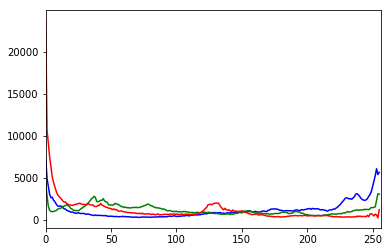

In [55]:
gray_img = rgb2gray(image)
color = ('b','g','r')
plt.figure()
for i,col in enumerate(color):
    histr = cv2.calcHist([image],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()


In [119]:
def calculateHogFeatures(gray_image, o, pixels, cells):
    features = hog(gray_image, orientations=o, 
                              pixels_per_cell=(pixels, pixels),
                              cells_per_block=(cells, cells), 
                              transform_sqrt=True, 
                              visualize=False, block_norm = "L2-Hys")
    return features
def calculateDaisyFeatures(gray_image):
    descs = daisy(gray_image, step=180, radius=2, rings=3, histograms=6,
                         orientations=8, visualize=False)
    return descs

def calculateDoG(gray_image):
    blobs_dog = blob_dog(gray_img, max_sigma=30, threshold=.1)
    blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)
    return blobs_dog

def calculateFeatures(imgs):
    hog_features = []
    dog_features = []
    daisy_features = []
    for img in imgs[0]:
        gray_img = rgb2gray(img)
        hog_features.append(calculateHogFeatures(gray_img,8,16,1))
        dog_features.append(calculateDoG(gray_img))
        #daisy_features.append(calculateDaisyFeatures(gray_img))
    return hog_features, dog_features#, daisy_features

features = calculateFeatures(category_imgs21 + category_imgs70 + category_imgs78)
'''
descs, descs_img = daisy(gray_img, step=180, radius=58, rings=3, histograms=6,
                         orientations=8, visualize=True)

print(descs)
fig, ax = plt.subplots()
ax.axis('off')
ax.imshow(descs_img)
descs_num = descs.shape[0] * descs.shape[1]
ax.set_title('%i DAISY descriptors extracted:' % descs_num)
plt.show()
'''

KeyboardInterrupt: 

In [116]:
#1189+2873+5686
print(len(features[0]))
print(len(labels))

labels = category_imgs21[1] + category_imgs70[1] + category_imgs78[1]
x_train, x_test, y_train, y_test = train_test_split(
    features[0], labels, test_size=0.25, random_state=42)
#print(features[0])

5686
9748


ValueError: Found input variables with inconsistent numbers of samples: [5686, 9748]

In [ ]:
def svmFit(x_train, y_train):
    print("Fitting the classifier to train")
    t0 = time()
    param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
                  'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                       param_grid, cv=5)
    clf = clf.fit(x_train, y_train)
    print("Completed in %0.3fs" % (time() - t0))
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)
    return clf

def saveModel(model, filename):
    print("Saving file...")
    joblib.dump(model, open(filename, 'wb'))
    print("File saved")
    
def loadModel(filename):
    print("loading file...")
    joblib.load(filename)
    print("Model loaded")
    
def svmPredict(x_test, y_test, model):
    print("Predicting the test set")
    t0 = time()
    y_pred = model.predict(x_test)
    print("Completed in %0.3fs" % (time() - t0))
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    
def randomForestFit(x_train, y_train, estimators, random_state):
    print("Fitting the classifier to train")
    t0 = time()
    rf = RandomForestRegressor(n_estimators = estimators, random_state = random_state)
    rf.fit(x_train, y_train);
    print("Completed in %0.3fs" % (time() - t0))
    return rf

def rfPredict(x_test, y_test, model):
    print("Predicting the test set")
    t0 = time()
    y_pred = model.predict(x_test)
    print("Completed in %0.3fs" % (time() - t0))
    errors = abs(y_pred - y_test)
    print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
    # Calculate mean absolute percentage error (MAPE)
    mape = 100 * (errors / y_test)
    # Calculate and display accuracy
    accuracy = 100 - np.mean(mape)
    print('Accuracy:', round(accuracy, 2), '%.')

svm = svm_fit(x_train, y_train)
svm_save(svm, 'SVM_test.sav')
svm_predict(x_test, y_test, svm)

0.3657043707714903
[0.35355339 0.35355339 0.35355339 0.35355339 0.35355339 0.35355339
 0.35355339 0.35355339 0.35586592 0.35586592 0.35586592 0.35023864
 0.35586592 0.35586592 0.35586592 0.34276754 0.35355339 0.35355339
 0.35355339 0.35355339 0.35355339 0.35355339 0.35355339 0.35355339
 0.39309483 0.39309483 0.39309483 0.31601563 0.24934737 0.37915527
 0.35351505 0.3250504  0.35355339 0.35355339 0.35355339 0.35355339
 0.35355339 0.35355339 0.35355339 0.35355339 0.38421301 0.34497207
 0.21823709 0.30865621 0.38421301 0.38421301 0.38421301 0.38421301
 0.35727286 0.35727286 0.32633223 0.35727286 0.35727286 0.35727286
 0.35727286 0.35727286 0.37446332 0.37446332 0.37446332 0.37446332
 0.33399298 0.37446332 0.26628179 0.34121667 0.         0.04178719
 0.01752399 0.17903523 0.61792756 0.61792756 0.44420548 0.07004045
 0.19525376 0.11895398 0.09972008 0.09372777 0.23918458 0.53906947
 0.53906947 0.53906947 0.38620535 0.38620535 0.38620535 0.38620535
 0.38620535 0.2929982  0.17177081 0.3726580

IndexError: invalid index to scalar variable.

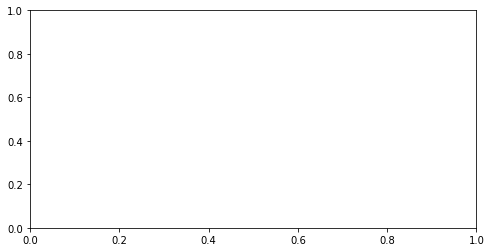

In [11]:
print(features[0][0])
print(features[1])

fig, ax = plt.subplots(1, figsize=(8, 4))

hog_image_rescaled = exposure.rescale_intensity(features[0][0][1], in_range=(0, 10))

ax.axis('off')
ax.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax.set_title('Histogram of Oriented Gradients')
plt.show()

In [ ]:
blobs_log = blob_log(gray_img, max_sigma=30, num_sigma=10, threshold=.1)

blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

blobs_dog = blob_dog(gray_img, max_sigma=30, threshold=.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

blobs_doh = blob_doh(gray_img, max_sigma=30, threshold=.01)

blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian',
          'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(image, interpolation='nearest')
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()


In [ ]:
fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)

fig, ax = plt.subplots(1, figsize=(8, 4))

hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax.axis('off')
ax.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax.set_title('Histogram of Oriented Gradients')
plt.show()

In [ ]:
print(gray_img)
coords = corner_peaks(corner_harris(gray_img), min_distance=5)

fig, (ax) = plt.subplots(1, figsize=(8, 4))

ax.axis('off')
ax.imshow(image)
ax.plot(coords[:, 1], coords[:, 0], 'or', ms=4)